# TP 9 – Calibration avancée : modèles de Lévy et SABR

Ce TP illustre le module `calibrate` de fypy (`FourierModelCalibrator`, `SabrModelCalibrator`).

Objectifs :
- calibrer un modèle de Lévy (par exemple Variance Gamma) sur une surface synthétique de prix;
- calibrer un modèle SABR sur un sourire de volatilité implicite;
- comprendre le rôle des poids (ex. pondération par l’inverse de la vega).

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from fypy.termstructures.DiscountCurve import DiscountCurve_ConstRate
from fypy.termstructures.EquityForward import EquityForward
from fypy.market.MarketSlice import MarketSlice
from fypy.market.MarketSurface import MarketSurface
from fypy.model.levy import VarianceGamma, BlackScholes
from fypy.model.slv.Sabr import Sabr
from fypy.pricing.fourier.ProjEuropeanPricer import ProjEuropeanPricer
from fypy.pricing.analytical.black_scholes import black76_price_strikes
from fypy.volatility.implied.ImpliedVolCalculator import ImpliedVolCalculator_Black76
from fypy.calibrate.FourierModelCalibrator import FourierModelCalibrator
from fypy.calibrate.SabrModelCalibrator import SabrModelCalibrator

%matplotlib inline

## 1. Calibration d’un modèle de Lévy (Variance Gamma)

Nous allons suivre la philosophie classique :
- générer une surface de prix synthétique avec un modèle "vrai" (ici Variance Gamma);
- construire un `MarketSurface` à partir de ces prix;
- appeler `FourierModelCalibrator` pour retrouver les paramètres.


In [3]:
# Paramètres de marché
S0 = 100.0
r = 0.01
q = 0.0

disc_curve = DiscountCurve_ConstRate(rate=r)
div_disc = DiscountCurve_ConstRate(rate=q)
fwd_curve = EquityForward(S0=S0, discount=disc_curve, divDiscount=div_disc)

# Modèle de Lévy "vrai" : Variance Gamma
vg_true = VarianceGamma(sigma=0.2, theta=-0.1, nu=0.6,
                       forwardCurve=fwd_curve, discountCurve=disc_curve)
pricer_vg_true = ProjEuropeanPricer(model=vg_true, N=2 ** 11, L=12.0)

ttms = [0.25, 0.5, 1.0, 2.0]
strikes = np.arange(60.0, 140.0, 5.0)
is_calls = np.ones(len(strikes), dtype=bool)

surface_vg = MarketSurface(forward_curve=fwd_curve, discount_curve=disc_curve)

for T in ttms:
    prix_slice = pricer_vg_true.price_strikes(T=T, K=strikes, is_calls=is_calls)
    mkt_slice = MarketSlice(T=T,
                            F=fwd_curve(T),
                            disc=disc_curve(T),
                            strikes=strikes,
                            is_calls=is_calls,
                            mid_prices=prix_slice)
    surface_vg.add_slice(T, mkt_slice)

ivc = ImpliedVolCalculator_Black76(disc_curve=disc_curve, fwd_curve=fwd_curve)
surface_vg.fill_implied_vols(calculator=ivc)

print('Surface VG synthétique créée avec', surface_vg.num_slices, 'slices.')

Surface VG synthétique créée avec 4 slices.


In [4]:
# Calibration d'un autre modèle de Lévy sur cette surface :
# pour la démonstration, on réutilise Variance Gamma avec un mauvais jeu de départ.
vg_calib = VarianceGamma(sigma=0.25, theta=-0.2, nu=0.4,
                        forwardCurve=fwd_curve, discountCurve=disc_curve)

calibrator_vg = FourierModelCalibrator(surface=surface_vg)

print('Paramètres "vrais" VG   :', vg_true.get_params())
print('Paramètres initiaux VG  :', vg_calib.get_params())

result_vg, pricer_vg_calib, model_prices_vg, target_prices_vg = calibrator_vg.calibrate(model=vg_calib)

print('Paramètres calibrés VG :', vg_calib.get_params())

Paramètres "vrais" VG   : [ 0.2 -0.1  0.6]
Paramètres initiaux VG  : [ 0.25 -0.2   0.4 ]
Starting model calibration
`gtol` termination condition is satisfied.
Function evaluations 6, initial cost 2.6735e+00, final cost 1.5858e-13, first-order optimality 2.53e-11.
Done model calibration, cost: 5.631641782589323e-07
Calibration Time:  0.16623330116271973
Paramètres calibrés VG : [ 0.19999999 -0.10000007  0.5999994 ]


La classe `FourierModelCalibrator` :
- parcourt la surface de marché pour empiler toutes les cibles (prix mid);
- construit un pricer Fourier (par défaut PROJ) adapté au modèle;
- crée un `Calibrator` générique avec les bons poids (par ex. inverse de la vega);
- lance l’optimisation et renvoie le résumé (`result_vg`) et les prix modèle calibrés.


## 2. Calibration d’un modèle SABR sur un sourire

Approche similaire, mais en travaillant directement sur les **volatilités implicites** plutôt que sur les prix :
- on génère une surface de prix avec un modèle simple (par ex. Black-Scholes avec vol non constante);
- on la convertit en surface de vols implicites (via `ImpliedVolCalculator`);
- on utilise `SabrModelCalibrator` pour ajuster les paramètres SABR à ces vols.


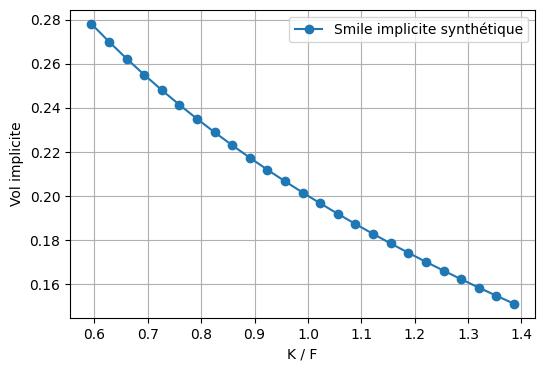

In [5]:
# Construisons un sourire synthétique en partant d'une vol Black-Scholes variable avec K
S0 = 100.0
r = 0.01
q = 0.0
T = 1.0

disc_curve = DiscountCurve_ConstRate(rate=r)
div_disc = DiscountCurve_ConstRate(rate=q)
fwd_curve = EquityForward(S0=S0, discount=disc_curve, divDiscount=div_disc)
F = fwd_curve(T)

Ks = np.linspace(60.0, 140.0, 25)
is_calls = np.ones(len(Ks), dtype=bool)

# Smile synthétique : vol(K) = vol_ATM + pente * log(K/F)
vol_atm = 0.2
slope = -0.15
vols_smile = vol_atm + slope * np.log(Ks / F)

prices_smile = black76_price_strikes(F=F, K=Ks, is_calls=is_calls,
                                    vol=vols_smile, disc=disc_curve(T), T=T)

slice_smile = MarketSlice(T=T,
                          F=F,
                          disc=disc_curve(T),
                          strikes=Ks,
                          is_calls=is_calls,
                          mid_prices=prices_smile)

surface_smile = MarketSurface(forward_curve=fwd_curve, discount_curve=disc_curve)
surface_smile.add_slice(T, slice_smile)

ivc = ImpliedVolCalculator_Black76(disc_curve=disc_curve, fwd_curve=fwd_curve)
surface_smile.fill_implied_vols(calculator=ivc)

plt.figure(figsize=(6, 4))
plt.plot(Ks / F, slice_smile.mid_vols, 'o-', label='Smile implicite synthétique')
plt.xlabel('K / F')
plt.ylabel('Vol implicite')
plt.grid(True)
plt.legend()
plt.show()

In [6]:
# Calibration SABR
sabr_model = Sabr(alpha=0.2, beta=0.5, rho=-0.1, nu=0.5,
                  forwardCurve=fwd_curve, discountCurve=disc_curve)

calibrator_sabr = SabrModelCalibrator(surface=surface_smile)

print('Paramètres SABR initiaux :', sabr_model.get_params())
result_sabr, sabr_pricer, _, target_vols = calibrator_sabr.calibrate(model=sabr_model)
print('Paramètres SABR calibrés :', sabr_model.get_params())

TypeError: Sabr.__init__() got an unexpected keyword argument 'nu'

`SabrModelCalibrator` :
- empile les vols implicites mid de la surface;
- construit une fonction `target_voler` qui renvoie \( \sigma_{SABR}(K_i,T_j) \) pour le vecteur de paramètres courant;
- utilise un `Calibrator` générique avec pertes quadratiques pour rapprocher \( \sigma_{SABR} \) des vols cibles.

**Pour aller plus loin :**
- ajouter du bruit sur les prix ou les vols cibles pour simuler des données de marché;
- expérimenter avec différentes initialisations et bornes de paramètres;
- comparer les résultats de calibration Lévy vs Heston sur la même surface (TP 4 + ce TP).